In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

2025-05-23 15:25:11.585283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748013911.809438      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748013911.873592      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

I0000 00:00:1748013925.975480      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [10]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

In [11]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

E0000 00:00:1748013931.769521      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748013932.045497      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1, Generator Loss: 0.7323, Discriminator Loss: 1.2391
Epoch 2, Generator Loss: 0.8905, Discriminator Loss: 1.0913
Epoch 3, Generator Loss: 0.6543, Discriminator Loss: 1.4867
Epoch 4, Generator Loss: 0.9005, Discriminator Loss: 1.2475
Epoch 5, Generator Loss: 1.0890, Discriminator Loss: 0.9757


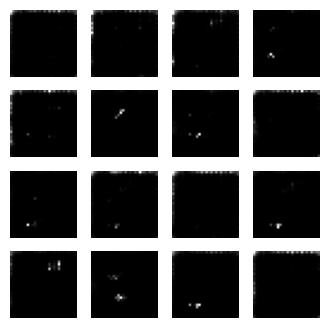

Epoch 6, Generator Loss: 0.7235, Discriminator Loss: 1.3938
Epoch 7, Generator Loss: 0.9721, Discriminator Loss: 1.2153
Epoch 8, Generator Loss: 1.0854, Discriminator Loss: 0.9357
Epoch 9, Generator Loss: 1.0548, Discriminator Loss: 1.0726
Epoch 10, Generator Loss: 1.0513, Discriminator Loss: 0.9663


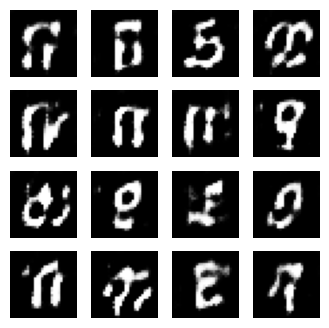

Epoch 11, Generator Loss: 0.9956, Discriminator Loss: 1.0243
Epoch 12, Generator Loss: 0.9355, Discriminator Loss: 1.1493
Epoch 13, Generator Loss: 1.1620, Discriminator Loss: 0.9335
Epoch 14, Generator Loss: 1.0009, Discriminator Loss: 1.0909
Epoch 15, Generator Loss: 0.8695, Discriminator Loss: 1.3624


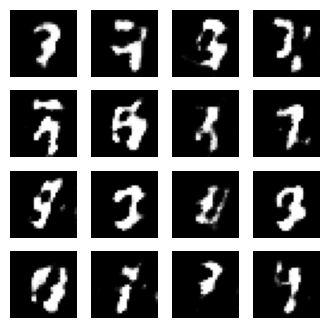

Epoch 16, Generator Loss: 1.0147, Discriminator Loss: 0.9573
Epoch 17, Generator Loss: 1.0178, Discriminator Loss: 1.1969
Epoch 18, Generator Loss: 1.0076, Discriminator Loss: 1.2437
Epoch 19, Generator Loss: 1.2563, Discriminator Loss: 1.0009
Epoch 20, Generator Loss: 1.2835, Discriminator Loss: 0.9373


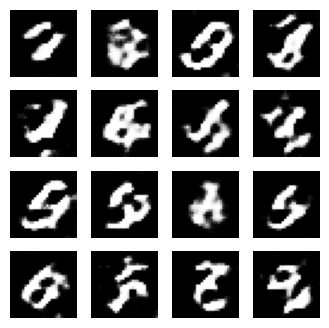

Epoch 21, Generator Loss: 1.0422, Discriminator Loss: 1.1235
Epoch 22, Generator Loss: 1.6420, Discriminator Loss: 0.7319
Epoch 23, Generator Loss: 1.1366, Discriminator Loss: 1.0046
Epoch 24, Generator Loss: 1.4987, Discriminator Loss: 0.9094
Epoch 25, Generator Loss: 1.2841, Discriminator Loss: 0.9071


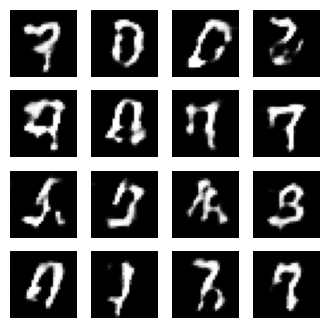

Epoch 26, Generator Loss: 1.1050, Discriminator Loss: 1.2068
Epoch 27, Generator Loss: 1.4642, Discriminator Loss: 0.9767
Epoch 28, Generator Loss: 1.4241, Discriminator Loss: 0.9474
Epoch 29, Generator Loss: 1.2621, Discriminator Loss: 1.1419
Epoch 30, Generator Loss: 1.1648, Discriminator Loss: 1.1395


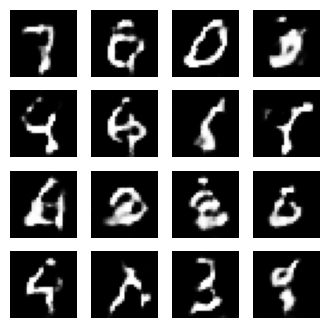

Epoch 31, Generator Loss: 1.2504, Discriminator Loss: 0.9877
Epoch 32, Generator Loss: 1.5038, Discriminator Loss: 0.8848
Epoch 33, Generator Loss: 1.2361, Discriminator Loss: 0.9691
Epoch 34, Generator Loss: 1.0054, Discriminator Loss: 1.1924
Epoch 35, Generator Loss: 1.1758, Discriminator Loss: 1.1223


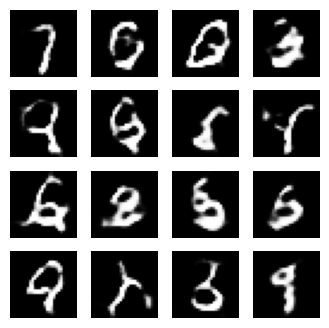

Epoch 36, Generator Loss: 1.0429, Discriminator Loss: 1.2623
Epoch 37, Generator Loss: 1.0530, Discriminator Loss: 1.1484
Epoch 38, Generator Loss: 1.1395, Discriminator Loss: 1.2070
Epoch 39, Generator Loss: 1.2102, Discriminator Loss: 0.8927
Epoch 40, Generator Loss: 1.0697, Discriminator Loss: 1.2214


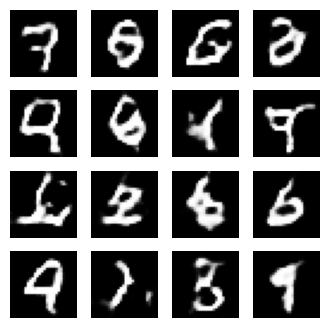

Epoch 41, Generator Loss: 0.8812, Discriminator Loss: 1.2449
Epoch 42, Generator Loss: 0.9136, Discriminator Loss: 1.2907
Epoch 43, Generator Loss: 0.9657, Discriminator Loss: 1.2609
Epoch 44, Generator Loss: 1.0227, Discriminator Loss: 1.1851
Epoch 45, Generator Loss: 1.0424, Discriminator Loss: 1.3593


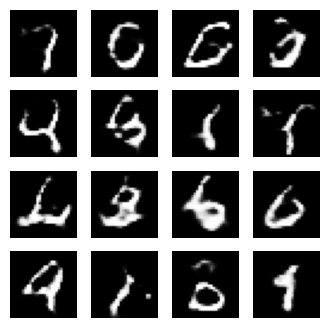

Epoch 46, Generator Loss: 0.7133, Discriminator Loss: 1.4384
Epoch 47, Generator Loss: 1.1060, Discriminator Loss: 1.2377
Epoch 48, Generator Loss: 1.0085, Discriminator Loss: 1.1696
Epoch 49, Generator Loss: 0.8067, Discriminator Loss: 1.3121
Epoch 50, Generator Loss: 1.1683, Discriminator Loss: 0.9775


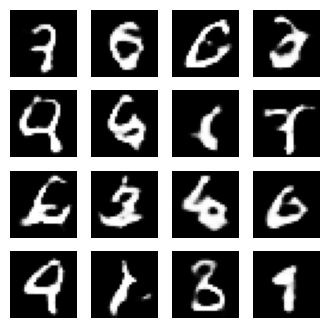

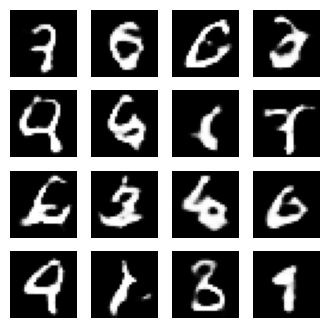

In [12]:
seed = tf.random.normal([16, 100])
EPOCHS = 50
train(train_dataset, EPOCHS)
generate_and_save_images(generator, EPOCHS, seed)